# Deep Learning for NSL KDD dataset

> NSL-KDD is a data set suggested to solve some of the inherent problems of the KDD'99 data set...
> [[University of New Brunswick](http://www.unb.ca/cic/research/datasets/nsl.html)]  

NSL KDD dataset has large number of columns which doesn't have significant correlation to decide whether current network session is *Normal* or an *Attack*. We performed Linear modeling of data and found that **36% of columns** *(considering 1e-5 as threshold for p value)* are significant in creating models of the dataset. Hence, we believe Deep Learning architectures like AutoEncoders and GANs will be best suitable.

We have special interest GAN networks due to their ability of learning about the data distribution by generating the distribution itself. We believe this can be utilized to generate Attack data distribution to help the discriminator model learn better.

## Data files  
>     * KDDTrain+.ARFF: The full NSL-KDD train set with binary labels in ARFF format  
>     * KDDTrain+.TXT: The full NSL-KDD train set including attack-type labels and difficulty level in CSV format  
>     * KDDTrain+_20Percent.ARFF: A 20% subset of the KDDTrain+.arff file  
>     * KDDTrain+_20Percent.TXT: A 20% subset of the KDDTrain+.txt file  
>     * KDDTest+.ARFF: The full NSL-KDD test set with binary labels in ARFF format  
>     * KDDTest+.TXT: The full NSL-KDD test set including attack-type labels and difficulty level in CSV format  
>     * KDDTest-21.ARFF: A subset of the KDDTest+.arff file which does not include records with difficulty level of 21 out of 21  
>     * KDDTest-21.TXT: A subset of the KDDTest+.txt file which does not include records with difficulty level of 21 out of 21  
> [[University of New Brunswick](http://www.unb.ca/cic/research/datasets/nsl.html)]  





In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
import statsmodels.api as sm
kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
kdd_train_2labels_y = pd.read_pickle("dataset/kdd_train_2labels_y.pkl")
results = sm.OLS(kdd_train_2labels_y.iloc[0:1000], kdd_train_2labels.iloc[0:1000, :-2]).fit()
#results.summary()

# Exploratory Data Analysis


## Feature Selection

We found that only 15 (out of 41) columns have P-values considering 1e-5 as threshold.   

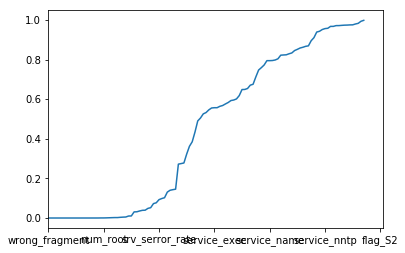

In [3]:
import warnings
warnings.filterwarnings('ignore')
results.pvalues.sort_values().plot();

In [4]:

print("Variables having P value lower than 1e-5")
results.pvalues[results.pvalues < 1e-5].sort_values()

Variables having P value lower than 1e-5


wrong_fragment                 1.577002e-39
same_srv_rate                  2.913320e-16
service_urp_i                  6.079849e-11
service_http                   1.801443e-10
dst_host_same_srv_rate         1.897631e-10
service_smtp                   2.699004e-10
dst_host_srv_rerror_rate       3.418082e-10
dst_host_srv_count             1.270372e-08
dst_host_same_src_port_rate    3.700446e-08
diff_srv_rate                  3.464595e-07
dst_host_srv_diff_host_rate    7.880064e-07
protocol_type_udp              1.163489e-06
service_IRC                    1.688161e-06
dst_host_count                 3.587908e-06
protocol_type_tcp              8.879575e-06
dtype: float64

## TSNE
- We found that Normal and Attack data are:
    * Not clearly seperable.
    * Not linearly sepearable 

![](images/TSNE-Train+Dataset.png)


In [5]:
#kdd_diff_level_train = pd.read_pickle("dataset/kdd_diff_level_train.pkl")
#kdd_diff_level_test = pd.read_pickle("dataset/kdd_diff_level_test.pkl")
#output_columns_2labels = ['Normal','Attack']
output_columns_2labels = ['Attack','Normal']
actual_value = pd.read_pickle("dataset/kdd_test_2labels_y.pkl");


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Positive", "\n False Negative \n Type II Error"],
             ["\n False Positive \n Type I Error", "\n True Negative"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, output_columns_2labels, normalize = True)

In [7]:
def get_count(pred_value):
    difficulty = pd.DataFrame({"Actual":actual_value, "Predict":pred_value, "difficulty_level":kdd_diff_level_test})
    #difficulty = pd.concat(difficulty, pd.Data)
    difficulty['accuracy'] = None
    difficulty.ix[difficulty.Actual == difficulty.Predict, "accuracy"] = 'Correct'
    difficulty.ix[difficulty.Actual != difficulty.Predict, "accuracy"] = 'Incorrect'
    diff_group = difficulty.loc[:,["difficulty_level", "accuracy", "Predict"]].groupby(["difficulty_level", "accuracy"])
    total_correct = sum(difficulty.Actual == difficulty.Predict)
    total_records = difficulty.shape[0]
    total_incorrect = total_records - total_correct
    print("Total Records:{}".format(total_records))
    return diff_group.count()

In [8]:
scores = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_scores.pkl")
accumulate_test_scores = scores.iloc[:,0:3]
#accumulate_test_scores

In [9]:
def evaluate(pred_pkl, score_pkl, name = 'DNN'):
    global accumulate_test_scores
    predictions = pd.read_pickle(pred_pkl)
    scores = pd.read_pickle(score_pkl)
    
    accumulate_test_scores = pd.concat([accumulate_test_scores, 
                                        pd.DataFrame({"{}_test_score"
                                                                  .format(name):
                                                                  scores.loc[:,"test_score"]})], 
                                       axis = 1,)
    #accumulate_test_scores = accumulate_test_scores.rename(columns = {"test_score":"{}_test_score".format(name)})
    #print(scores.sort_values("test_score", ascending=False))

    df_sorted = scores.sort_values("test_score", ascending=False).iloc[0,0:3]
    epoch = int(df_sorted['epoch'])
    n_o_f = int(df_sorted['no_of_features'])
    h_l = int(df_sorted['hidden_layers'])
    print("Best model choosen is: Epochs:{} Number of Features:{} Hidden Layers:{}".format(epoch,n_o_f,h_l))
    df_pred = predictions["{}_{}_{}".format(epoch,n_o_f,h_l)] #.round(2)
    Attack_index = actual_value == 0
    Normal_index = actual_value == 1

    #df_pred[Attack_index].plot(kind='line', figsize=(20,5), title="Prediction of Attack")
    #df_pred[Normal_index].plot(kind='line', figsize=(20,5), title="Prediction of Normal")
    
    pred_value = df_pred["Prediction"] #np.argmax(df_pred.values, axis=1)
    plot(pred_value)
    return scores.sort_values("test_score", ascending=False)

# Evaluating Dense Network

![Fully Connected Network](images/NSL_KDD_FullyConnectedNetwork.jpg)

We used Fully connected Neural Network to observe the behavior of model training on NSL KDD data under various hyper parameter configurations as stated below:

- Feature Reduction  
We tried to reduce the number of features to understand how much the data can be compressed while still able to generalize enough for test dataset.
    
- Number of Hidden layers  
    We wanted to observe how many layers of dense networks may be required to capture the non-leanarity of the data. This understanding may prove useful while training other deep learning architectures.
- Epochs, learning rate   
    We wanted to get an understanding of how much time/resources will be required to train the model.

Best model choosen is: Epochs:20 Number of Features:32 Hidden Layers:4


,epoch,no_of_features,hidden_layers,train_score,test_score,time_taken
6,20,32,4,0.892046,0.897933,19.431615
5,20,8,4,0.869027,0.885823,22.556436
1,20,8,2,0.905382,0.881254,17.043705
11,20,64,6,0.901334,0.881033,39.989143
3,20,64,2,0.919432,0.862757,8.935693
0,20,4,2,0.943007,0.845369,16.299912
4,20,4,4,0.850294,0.835788,9.173420
10,20,32,6,0.945309,0.829755,78.154274
7,20,64,4,0.948166,0.817158,39.293368
2,20,32,2,0.956342,0.788769,21.211315


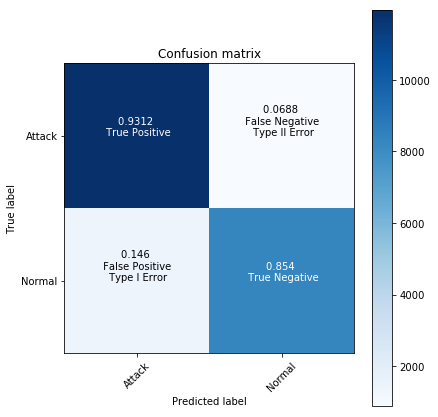

In [10]:
evaluate("dataset/tf_dense_only_nsl_kdd_predictions.pkl",
         "dataset/tf_dense_only_nsl_kdd_scores.pkl", "DenseNetwork")

# Variational Autoencoders 

Variational Autoencoders can reduce the features by initially compressing the data and then calculating mean and variance of the compressed data features. Mean and variance is used to approximate data distribution (Z) of each compressed feature. The model learns by optimzing loss occured while reproducing the actual data using the Z data distribution.  

## Predict using Softmax
In order to predict whether current network session is Normal or Attack, we coupled Softmax with layer producing Z data distribution.

![VAE with Softmax](images/VAE_withSoftmax.jpg)


Best model choosen is: Epochs:20 Number of Features:8 Hidden Layers:6


,epoch,no_of_features,hidden_layers,train_score,test_score,time_taken
9,20,8,6,0.896606,0.892832,18.282973
2,20,16,2,0.910498,0.884315,52.052245
8,20,4,6,0.900099,0.883960,79.896244
7,20,32,4,0.876999,0.877395,109.307383
11,20,32,6,0.872832,0.858321,56.983235
4,20,4,4,0.878309,0.857967,36.212009
1,20,8,2,0.831117,0.841466,46.666873
6,20,16,4,0.930304,0.836985,8.436142
10,20,16,6,0.882993,0.821327,9.489717
0,20,4,2,0.902123,0.810504,14.201883


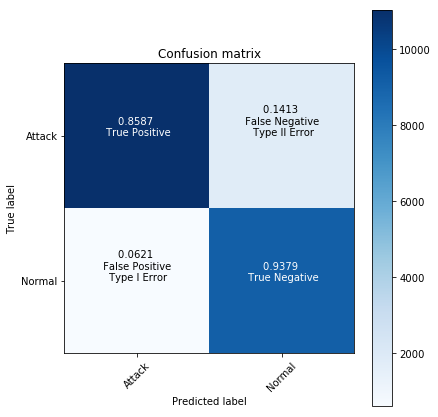

In [11]:
evaluate("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl",
         "dataset/tf_vae_dense_trained_together_nsl_kdd_scores.pkl", "VAE_with_Softmax")

## Include dependent Variable as feature.

Another approach we took is to train VAE to reproduce Normal/Attack labels itself during Training cylce. While testing, we would replace the labels with **random values(0~1)** and use VAE to generate correct values of the labels.

![VAE with Softmax](images/VAE_withLabel.jpg)


## using VAE Loss

< explain the variation >

Best model choosen is: Epochs:20 Number of Features:4 Hidden Layers:6


,epoch,no_of_features,hidden_layers,train_score,test_score,time_taken
8,20,4,6,0.856326,0.869633,58.462562
4,20,4,4,0.865375,0.862535,62.101604
11,20,32,6,0.904509,0.845413,7.644736
1,20,8,2,0.920067,0.842264,63.524530
10,20,16,6,0.778060,0.840845,73.350619
9,20,8,6,0.844658,0.833126,77.473783
6,20,16,4,0.905223,0.824876,135.412426
3,20,32,2,0.950548,0.823279,11.461275
7,20,32,4,0.903477,0.809218,36.302240
0,20,4,2,0.943086,0.790232,21.424091


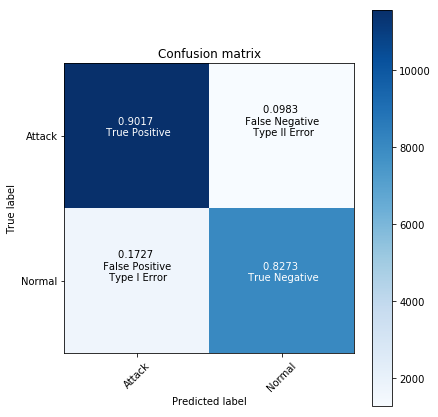

In [12]:
evaluate("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions.pkl",
         "dataset/tf_vae_only_vae_loss_nsl_kdd_scores.pkl", "VAE_with_label")

## Using MSE Loss

Best model choosen is: Epochs:20 Number of Features:8 Hidden Layers:4


,epoch,no_of_features,hidden_layers,train_score,test_score,time_taken
5,20,8,4,0.942610,0.895848,58.912110
8,20,4,6,0.909906,0.877661,155.164080
9,20,8,6,0.927290,0.831396,83.473590
3,20,32,2,0.949992,0.829888,48.012730
0,20,4,2,0.955945,0.828691,19.451182
6,20,16,4,0.844975,0.827848,101.502000
4,20,4,4,0.959200,0.822392,40.326999
11,20,32,6,0.933323,0.821993,69.000163
7,20,32,4,0.953008,0.813831,6.107059
10,20,16,6,0.947214,0.806246,8.385378


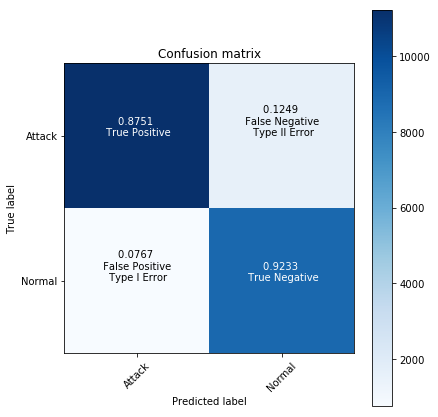

In [13]:
evaluate("dataset/tf_vae_only_nsl_kdd_predictions.pkl",
         "dataset/tf_vae_only_nsl_kdd_scores.pkl", "VAE_with_label_MSE_loss")

# LSTM Autoencoder Model

LSTM Autoencoder, aka Seq2Seq, model is generally used to predict sequences of numbers (time dependent) given another sequence of numbers. LSTM encoders generates a context vector using input sequence which is passed on to decoder to generate the output.  
We coupled LSTM decoder cells with Softmax layer to generate probability whether current session is Normal or Attack  


![LSTM Encoder Decoder Model](images/LSTMseq2seq_withsoftmax.jpg)

In [14]:
#evaluate("dataset/keras_lstm_nsl_kdd_predictions.pkl",
#         "dataset/keras_lstm_nsl_kdd_scores.pkl", "VAE_with_label_MSE_loss")

# Generative Adversarial Networks

## General Concept

GANs utilizes two networks, Generator and Discriminator, to learn about data distribution by generating the data itself.
- Generator Network is responsible to produce data of interest using random values.
- Discriminator Network is responsible to identify between fake data produced by Generator and Actual sample of data.

The optimized state of GANs is when Generator starts to produce enough realistic data so discriminator cannot distinguish between real data and generated data



![Generative Advarsarial Networks](images/NSL_KDD_GAN_original_idea.jpg)

## GANs - For Hypothesis testing

We suggest a learning model where GANs can be used for Hypothesis testing. Assume we have 2 data distributions D1 and D2:
- Generator will be responsible to produce D2 distribution using random values
- Discriminiator will be responsible to distinguish between D1 and D2 distributions.  

Basically, discriminator will output probability between 0~1 whether current data is D1 or not. In this way we can decide a significance level based on which it can be decided to either Accept or Reject Null hypothesis i.e. whether current data is D1 or not.

![GAN_hypo_optim_state](images/NSL_KDD_GAN_initial_state.jpg)
![GAN_hypo_optim_state](images/NSL_KDD_GAN_hypo_optim_state.jpg)

### GANs for NSL KDD dataset 



![GANs for NSL KDD dataset ](images/NSL_KDD_GAN_attack_hypothesis.jpg)

# Compare Results

In [15]:
accumulate_test_scores['param'] = accumulate_test_scores[['epoch','no_of_features', 'hidden_layers']].apply(lambda x : 'epoch:{}_features:{}_layers:{}'.format(x[0],x[1], x[2]), axis=1)

In [16]:
accumulate_test_scores = accumulate_test_scores.drop(['epoch','no_of_features', 'hidden_layers'], axis = 1)

In [17]:
accumulate_test_scores.set_index("param", inplace = True)

In [18]:
accumulate_test_scores

,DenseNetwork_test_score,VAE_with_Softmax_test_score,VAE_with_label_test_score,VAE_with_label_MSE_loss_test_score
param,,,,
epoch:20_features:4_layers:2,0.845369,0.810504,0.790232,0.828691
epoch:20_features:8_layers:2,0.881254,0.841466,0.842264,0.802874
epoch:20_features:16_layers:2,0.788769,0.884315,0.767876,0.794491
epoch:20_features:32_layers:2,0.862757,0.773554,0.823279,0.829888
epoch:20_features:4_layers:4,0.835788,0.857967,0.862535,0.822392
epoch:20_features:8_layers:4,0.885823,0.771735,0.772401,0.895848
epoch:20_features:16_layers:4,0.897933,0.836985,0.824876,0.827848
epoch:20_features:32_layers:4,0.817158,0.877395,0.809218,0.813831
epoch:20_features:4_layers:6,0.430979,0.883960,0.869633,0.877661


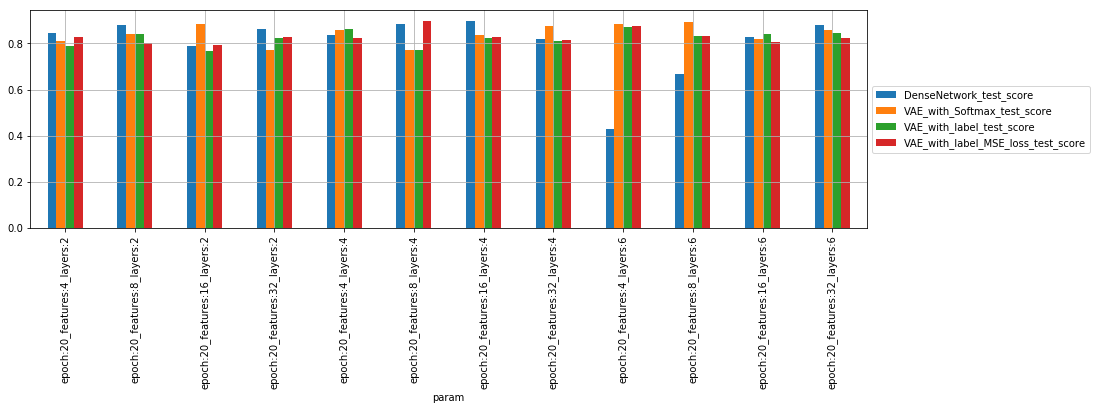

In [19]:
f = plt.figure()
accumulate_test_scores.plot(kind='bar', figsize=(15,4), ax=f.gca(),grid=True, )
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [20]:
accumulate_test_scores.to_csv("dataset/results.csv")